### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level.

In [2]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz

--2018-10-07 21:08:20--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.1, 2620:100:601a:1::a27d:701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2018-10-07 21:08:21--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6ab355917592848d3ab952ccd6.dl.dropboxusercontent.com/cd/0/get/ASawTrg4_feAxPndPCaPW2KXOPdurhrNFM2Q86pjyC9et4HBAJ3441ppxBuFm35B1j7OYEy94gxuvYrQSPcQT7xJm4kCu_v-tgXTMUH3eGfjCoIZsG4c4qjMqeY9UK4bnoATNC-6noV829Q8ARUzHzpVHJKuSHO2Q2XzowKnGnpfOXI15Rh-g-DJyyikIqX4rh0/file?dl=1 [following]
--2018-10-07 21:08:21--  https://uc6ab355917592848d3ab952ccd6.dl.dropboxusercontent.com/cd/0/get/ASawTrg4_feAxPndPCaPW2

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [21]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [22]:
# get all unique characters from lines (including capital letters and symbols)
tokens = np.unique(list(' '.join(lines)))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a TF-friendly integer vector.

In [23]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token : idx for idx, token in enumerate(tokens)}

In [24]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [25]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype='int32'):
    """Casts a list of lines into tf-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [26]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [27]:
import tensorflow as tf
import keras, keras.layers as L
sess = tf.InteractiveSession()

/home/kirilenko_en/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [90]:
class FixedWindowLanguageModel:
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        You can stack several convolutions at once
        """
        
        #YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        
        strides=1
        batch_input = L.Input(shape=(None,), dtype='int32')
        emb_layer = L.Embedding(input_dim=n_tokens, output_dim=emb_size)

        embedded_input = emb_layer(batch_input)


        conv_5 = L.Conv1D(filters=hid_size, kernel_size=5, strides=strides, padding='causal')(embedded_input)
        conv_6 = L.Conv1D(filters=hid_size, kernel_size=6, strides=strides, padding='causal')(embedded_input)
        conv_7 = L.Conv1D(filters=hid_size, kernel_size=7, strides=strides, padding='causal')(embedded_input)

        concat_conv = L.Concatenate(axis=2)([conv_5, conv_6, conv_7])
        logits = L.TimeDistributed(L.Dense(units=n_tokens))(concat_conv)
        
    
        self.model = keras.models.Model(inputs=batch_input, outputs=logits)
        
        #END OF YOUR CODE
        
        self.prefix_ix = tf.placeholder('int32', [None, None])
        self.next_token_probs = tf.nn.softmax(self(self.prefix_ix)[:, -1])
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        
        return self.model(input_ix)
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, sess=sess):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        probs = sess.run(self.next_token_probs, {self.prefix_ix: to_matrix([prefix])})[0]
        return dict(zip(tokens, probs))
        

In [120]:
window_lm = FixedWindowLanguageModel()

In [121]:
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_lm_out = window_lm(dummy_input_ix)
# note: tensorflow and keras layers only create variables after they're first applied (called)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_lm_out)

assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [122]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_lm_out_2 = window_lm(dummy_input_ix_2)
dummy_logits_2 = sess.run(dummy_lm_out_2)
assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [123]:
def compute_lengths(input_ix, eos_ix=token_to_id[EOS]):
    """ compute length of each line in input ix (incl. first EOS), int32 vector of shape [batch_size] """
    count_eos = tf.cumsum(tf.to_int32(tf.equal(input_ix, eos_ix)), axis=1, exclusive=True)
    lengths = tf.reduce_sum(tf.to_int32(tf.equal(count_eos, 0)), axis=1)
    return lengths

print('matrix:\n', dummy_input_ix.eval())
print('lengths:', compute_lengths(dummy_input_ix).eval())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
lengths: [ 5  9 15]


In [124]:
input_ix = tf.placeholder('int32', [None, None])

logits = window_lm(input_ix[:, :-1])
probs = tf.nn.softmax(logits)
reference_answers = input_ix[:, 1:]

reference_answers_ohe = tf.one_hot(reference_answers, depth=n_tokens)
# Your task: implement loss function as per formula above
# your loss should only be computed on actual tokens, excluding padding
# predicting actual tokens and first EOS do count. Subsequent EOS-es don't
# you will likely need to use compute_lengths and/or tf.sequence_mask to get it right.

lengths = tf.subtract(compute_lengths(reference_answers), 1)
length_mask = tf.sequence_mask(lengths, tf.shape(reference_answers)[1], dtype=tf.float32)
multiply_probs = tf.multiply(reference_answers_ohe, probs)
probs_true_symbols = tf.reduce_max(multiply_probs, axis=-1)

log_probs = tf.log(probs_true_symbols)

log_probs_without_inf = tf.where(tf.is_inf(log_probs), tf.ones_like(log_probs) * (-3), log_probs)
log_probs_end = tf.multiply(log_probs_without_inf, length_mask)
# print(log_probs_without_inf.shape)
sum_probs = tf.reduce_sum(log_probs_end, axis=-1)
loss = -tf.reduce_mean(sum_probs)


# operation to update network weights
train_step = tf.train.AdamOptimizer().minimize(loss)

In [125]:
loss_1 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=50)})
loss_2 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=100)})
print(loss_1, loss_2)
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use tf.sequence_mask. Beware +/-1 errors. And be careful when averaging!'

37.64 37.64


### Training loop

Now let's train our model on minibatches of data

In [126]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

sess.run(tf.global_variables_initializer())
batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []

In [127]:
def score_lines(dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
        batch_ix = to_matrix(dev_lines[i: i + batch_size])
        dev_loss_num += sess.run(loss, {input_ix: batch_ix}) * len(batch_ix)
        dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(lm, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by lm
    :param temperature: samples proportionally to lm probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    while True:
        token_probs = lm.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

if len(dev_history) == 0:
    dev_history.append((0, score_lines(dev_lines, batch_size)))
    print("Before training:", generate(window_lm, 'Bridging'))

Before training: BridginghôimF.âGÜç|M#Z9w[B^ngMaUL[]DŁÉKχ'śçk<TRPíZν_3Iô9tôzŁŁIő\y-Z$Qöσ$õä`GHwpM|χ&lαBlO%TFça33śm!^b


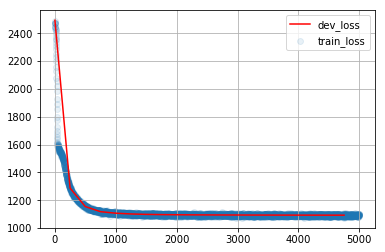

Generated examples (tau=0.5):
 Stathin math ion dithe  ofor mathine the ation complexist are con and mathe sean intere the exploves
 anding and werks ffre the aralizetion and ing pre antically, whe shal aral serontition the s ase for
 Montr and chesent ar ating ion ar Anssed the s aprestive poral the armprestition tomeder for the sof
Scoring dev...


100%|██████████| 4990/4990 [10:50<00:00,  1.01s/it]

#4999 Dev loss: 1092.355


In [129]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i, _ = sess.run([loss, train_step], {input_ix: batch})
    train_history.append((i, loss_i))
#     print(train_history)
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(window_lm, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [130]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(window_lm, temperature=0.5))

Final dev loss: 1092.35540323
 Sentor the of ame Reconstis th he the explise for tion ant coner th suprobe monthe of the orapliag e
 Pentrect of the and me the taling thes and tha deaterale an with and pestore int of imatice fince pe
 Astombited and arale and ale rof lations of the ced ine preverien and the and arne goresing are sere
 Antoris con textion the spropes with sioner A contion tha nisy tha coracerat on metented te sentitin
 Horksurg anthe trol pering ind we phe weres deding the medition the temalal inath s pale be mation f
 Spation delinge on the the  nequere the consis the sescon the ondertere troble thar wo d suster the 
 Deand bation the the loremont of ther the ara dentim nod the dely ffice the sing ale mode co perense
 Armalization coully and of amel alesent on matis anteraction torising and the torin tha ne wirg area
 Res ita dong me the the underes an with approdict as ond as inge ar inen tores forment res both in t
 Armation ; Aus toon and the 3 mons the leration and

### RNN Language Models

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [142]:
class RNNLanguageModel:
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        """
        
        # YOUR CODE - create layers/variables/etc
        
        batch_input = L.Input(shape=(None,), dtype='int32')
        emb_layer = L.Embedding(input_dim=n_tokens, output_dim=emb_size)

        embedded_input = emb_layer(batch_input)
        
        hidden_states = L.CuDNNLSTM(units=hid_size, return_sequences=True)(embedded_input)
        
        logits = L.TimeDistributed(L.Dense(units=n_tokens))(hidden_states)
    
        self.model = keras.models.Model(inputs=batch_input, outputs=logits)
        
        
        self.prefix_ix = tf.placeholder('int32', [None, None])
        self.next_token_probs = tf.nn.softmax(self(self.prefix_ix)[:, -1])
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
    
        return self.model(input_ix)
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, sess=sess):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        probs = sess.run(self.next_token_probs, {self.prefix_ix: to_matrix([prefix])})[0]
        return dict(zip(tokens, probs))
        

In [153]:
rnn_lm = RNNLanguageModel()

In [154]:
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_lm_out = rnn_lm(dummy_input_ix)
# note: tensorflow and keras layers only create variables after they're first applied (called)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_lm_out)

assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [155]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_lm_out_2 = rnn_lm(dummy_input_ix_2)
dummy_logits_2 = sess.run(dummy_lm_out_2)
assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [breaking](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_global_norm).

Your task here is to prepare tensorflow graph that would minimize the same loss function. If you encounter large loss fluctuations during training, please add gradient clipping using urls above.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [160]:
input_ix = tf.placeholder('int32', [None, None])

logits = rnn_lm(input_ix[:, :-1])
reference_answers = input_ix[:, 1:]

# Copy the loss function and train step from the fixed-window model training
probs = tf.nn.softmax(logits)
reference_answers_ohe = tf.one_hot(reference_answers, depth=n_tokens)

lengths = tf.subtract(compute_lengths(reference_answers), 1)
length_mask = tf.sequence_mask(lengths, tf.shape(reference_answers)[1], dtype=tf.float32)
multiply_probs = tf.multiply(reference_answers_ohe, probs)
probs_true_symbols = tf.reduce_max(multiply_probs, axis=-1)

log_probs = tf.log(probs_true_symbols)

log_probs_without_inf = tf.where(tf.is_inf(log_probs), tf.ones_like(log_probs) * (-3), log_probs)
log_probs_end = tf.multiply(log_probs_without_inf, length_mask)
sum_probs = tf.reduce_sum(log_probs_end, axis=-1)
loss = -tf.reduce_mean(sum_probs)

# and the train step
train_step = tf.train.AdamOptimizer().minimize(loss)

In [161]:
loss_1 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=50)})
loss_2 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=100)})
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. Hint: use tf.sequence_mask. Be careful when averaging!'

### RNN: Training loop

In [162]:
sess.run(tf.global_variables_initializer())
batch_size = 128
score_dev_every = 250
train_history, dev_history = [], []

dev_history.append((0, score_lines(dev_lines, batch_size)))

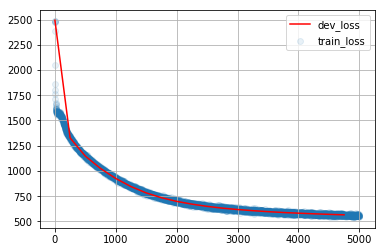

Generated examples (tau=0.5):
 Distributed Statistical Convex Model for Probabilistic Information ; We consider the problem of logi
 Automatic Measure of Automatic Algorithm for Structural Sentiment ; The problem of language matching
 Language Sensory Labels for Measure of Deep Neural Networks ; Distributed a power be an optimal comp
Scoring dev...



100%|██████████| 5000/5000 [20:30<00:00,  2.40s/it]


#4999 Dev loss: 561.260


In [163]:
for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i, _ = sess.run([loss, train_step], {input_ix: batch})
    train_history.append((i, loss_i))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(rnn_lm, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [165]:
assert np.mean(train_history[:10]) > np.mean(train_history[-10:]), "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_lm, temperature=0.5))

Final dev loss: 561.260309618
 Techniques for a new model to supervised from deep learning ; We study the structure of complexity o
 Deep Learning of Classification ; We present a new methods for decomposition methods are allows with
 A the Selection of a single counterfactual influence ; We introduce a new algorithm to a probability
 A Convolutional Neural Networks and Video Recognition of Selection ; A single space for the scale fo
 Semantic Were Learning and Search for Stochastic Analysis ; The computational performance of the int
 Fast Selectional Inference of Computer and Semantic Results for Internet ; We propose a novel optima
 An Adaptive Approach of Stochastic Analysis of Sensor Analysis ; A services are subspace constraint 
 Complexity Capabilition of Fine-Basced Learning ; In this paper, we propose a novel attention of a g
 A Gaussian Regions for   Internet Tologic Person System ; Considered the state-of-the-art knowledge 
 Semantic Methods for End-to-End Deep Learning for S

### Bonus quest: Ultimate Language Model

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_